# Project: Evaluating Algorithms to Split Single Scans with Two X-rays
## Objective: Develop a reliable method to split double X-ray scans into individual images before DICOMization
---
### Background

In the BB-Collection, we identified several TIFF scans containing two X-rays per file, most commonly (but not exclusively) in the *Elbow*, *Foot&Ankle*, *Hand&Wrist*, *Knee* sub-folders. We need to separate these scans into individual X-ray images. 

### Strategy

We've determined two primary approaches for this task:

1. Classic Image-Processing
2. Machine Learning / Deep Learning

#### Classic Image-Processing
Image processing algorithms typically involve an *enhancement* step (noise reduction, brightness/contrast tweaking) and a *feature detection* step (finding points, edges, lines, similar areas).  
After appropriately tuning a small set of parameters (such as threshold values), these algorithms can be set to run unsupervised on the entire dataset.  
**Pros:** No need for data labeling for a training pass. The process can run "unsupervised" after setting parameters.  
**Cons:** The lack of robustness. The images need to be fairly consistent for a successful *feature detection* pass.

#### Machine Learning / Deep Learning
ML/DL methods usually involve training an algorithm on a labeled traing-set. The trained algorithm (*trained model*) is then used for *prediction/inference* on the entire data-set.  
DL in particular uses artificial neural networks (ANN) as the *learning* algorithm.  
**Pros:** ANNs can recognize complex classes of objects, regardless of their position, rotation, size, etc. They are also fairly insensitive to background noise.  
**Cons:** Requires the preparation of a labeled training-set, which can be time-consuming.  

We will evaluate these approaches based on their potential benefits and challenges, specifically within the context of the BB-Collection.

## Testing classic image-processing algorithms
---
#### Canny edge detection + Hough lines
Canny Edge Detection and Hough Lines Transformation are key image-processing algorithms used for identifying and interpreting features in an image.  
The Canny algorithm effectively detects edges by reducing noise and isolating the most structurally significant boundaries.  
The Hough Lines algorithm can then interpret these edges, identifying where they align to form straight lines.  
These two algorithms are often used in conjunction due to their complementary nature: Canny outlines the main features while Hough Lines interprets these features' structure, together providing a robust method for understanding and extracting meaningful information from images.

In [1]:
import cv2
import numpy as np
from scipy.stats import mode
from collections import namedtuple
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from multiprocessing import Pool
import random as rnd
from PIL import Image
from fastai.vision.all import *

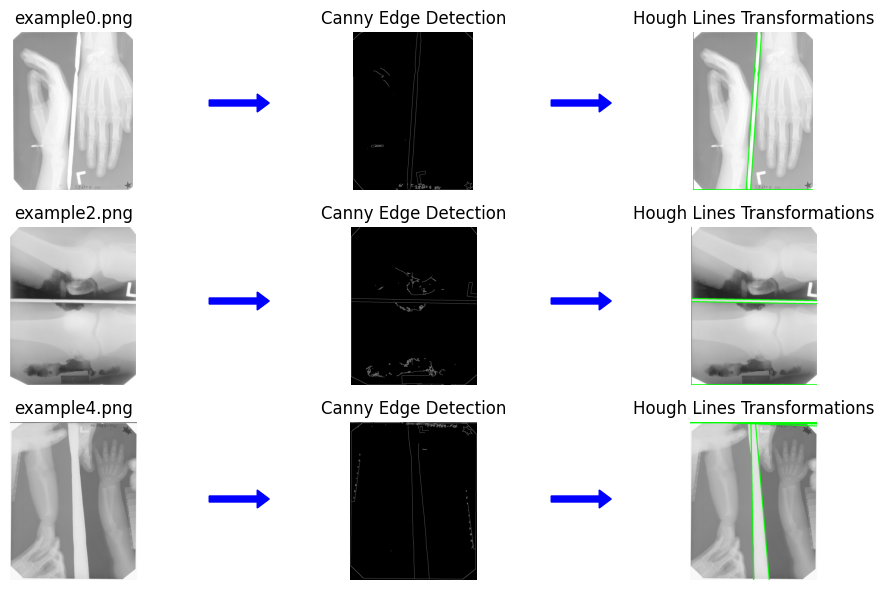

In [2]:
image_files = ['images/example0.png','images/example2.png','images/example4.png']
Line = namedtuple('Line', ['x1', 'y1', 'x2', 'y2'])
fig, axs = plt.subplots(len(image_files), 3, figsize=(12, 2*len(image_files)))

def apply_filters(image_file):
    # Load image
    original = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    # Apply Canny edge detection
    canny = cv2.Canny(original, 50, 150)

    # Apply Hough Lines detection
    lines = cv2.HoughLines(canny, 1, np.pi / 180, 200)
    hough = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)  # Convert to color image for line overlay

    # Draw HoughLines in green
    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 3000 * (-b))
            y1 = int(y0 + 3000 * a)
            x2 = int(x0 - 3000 * (-b))
            y2 = int(y0 - 3000 * a)
            cv2.line(hough, (x1, y1), (x2, y2), (0, 255, 0), 5)  # Draw lines in green

    return original, canny, hough

for idx, img_file in enumerate(image_files):
    original, canny, hough = apply_filters(img_file)

    # Show images
    axs[idx, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axs[idx, 1].imshow(canny, cmap='gray')
    axs[idx, 2].imshow(cv2.cvtColor(hough, cv2.COLOR_BGR2RGB))

    # Hide axes
    for a in axs[idx]:
        a.axis('off')

    # Add titles
    axs[idx, 0].set_title(img_file)
    axs[idx, 1].set_title('Canny Edge Detection')
    axs[idx, 2].set_title('Hough Lines Transformations')

    # Draw arrows between the images
    arrow1 = plt.Arrow(0.33, 0.16 + idx*0.33, 0.05, 0, width=0.05, color='blue', transform=fig.transFigure, clip_on=False)
    arrow2 = plt.Arrow(0.615, 0.16 + idx*0.33, 0.05, 0, width=0.05, color='blue', transform=fig.transFigure, clip_on=False)
    fig.add_artist(arrow1)
    fig.add_artist(arrow2)

plt.tight_layout()
plt.show()

The algorithm appears to accurately detect two x-rays, even though it also identifies some unwanted lines along the borders. We can filter them out and compute a single line by averaging the relevant lines.  
This final averaged line should represent an optimal location to split the scan.

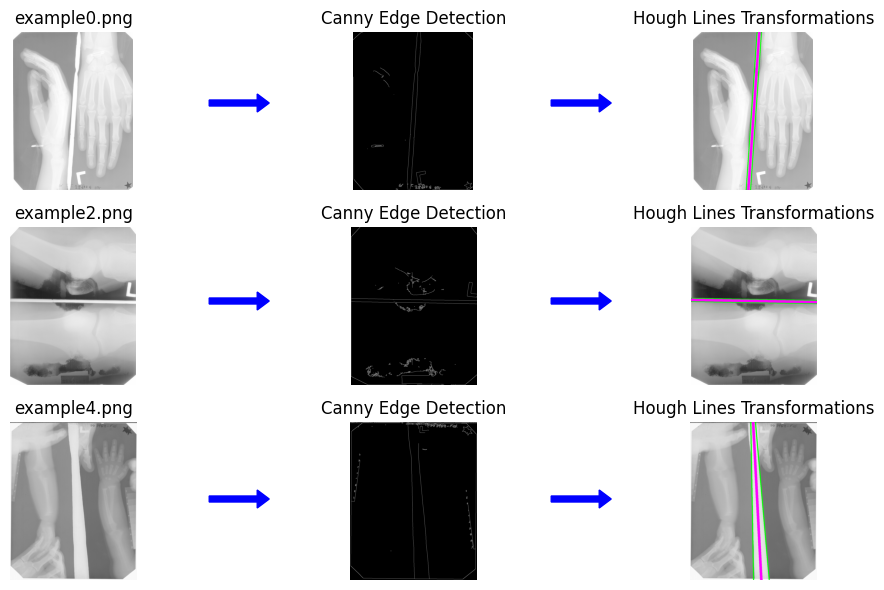

In [3]:
image_files = ['images/example0.png','images/example2.png','images/example4.png']
Line = namedtuple('Line', ['x1', 'y1', 'x2', 'y2'])
fig, axs = plt.subplots(len(image_files), 3, figsize=(12, 2*len(image_files)))

# Given a list of lines calculate an "average" line
def cut_points(lines, img):
    height, width, _ = img.shape
    if is_vertical(lines[0]):
        x1s = [line.x1 for line in lines]
        x2s = [line.x2 for line in lines]
        if lines[0].y1 < lines[0].y2:
            line = Line(int(np.mean(x1s)), 0, int(np.mean(x2s)), height)
        else:
            line = Line(int(np.mean(x1s)), height, int(np.mean(x2s)), 0)
        cv2.line(img, (line.x1, line.y1), (line.x2, line.y2), (255,0,255), 15)
    else:
        y1s = [line.y1 for line in lines]
        y2s = [line.y2 for line in lines]
        line = Line(0, int(np.mean(y1s)), width, int(np.mean(y2s)))
        cv2.line(img, (0, line.y1), (width, line.y2), (255,0,255), 15)
        
def is_vertical(line):
    dx = abs(line.x2 - line.x1)
    dy = abs(line.y2 - line.y1)
    return dy > dx
    
def clip_line_to_image(line, w, h):
    x1, y1, x2, y2 = line
    # Define potential intersections with image boundaries
    if x2 - x1 == 0:  # vertical line, avoid division by zero
        left = right = None
    else:
        left = (0, y1 + (y2 - y1) * (-x1) / (x2 - x1))
        right = (w, y1 + (y2 - y1) * (w - x1) / (x2 - x1))
    
    if y2 - y1 == 0:  # horizontal line, avoid division by zero
        top = bottom = None
    else:
        top = (x1 + (x2 - x1) * (-y1) / (y2 - y1), 0)
        bottom = (x1 + (x2 - x1) * (h - y1) / (y2 - y1), h)

    # Consider only points within image boundaries
    pts = [pt for pt in [left, right, top, bottom] if pt is not None and 0 <= pt[0] <= w and 0 <= pt[1] <= h]
    pts.sort(key=lambda pt: (pt[0] - x1) ** 2 + (pt[1] - y1) ** 2)
    return int(pts[0][0]), int(pts[0][1]), int(pts[-1][0]), int(pts[-1][1])

def apply_filters(image_file):
    found_lines = []
    original = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    canny = cv2.Canny(original, 50, 150)
    lines = cv2.HoughLines(canny, 1, np.pi / 180, 200)
    hough = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)  # Convert to color image for line overlay
    height, width = original.shape
    left_boundary = width * 0.2
    right_boundary = width * 0.8
    top_boundary = height * 0.2
    bottom_boundary = height * 0.8

    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * a)
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * a)
            x1, y1, x2, y2 = clip_line_to_image((x1, y1, x2, y2), width, height)
            if (left_boundary <= x1 <= right_boundary and left_boundary <= x2 <= right_boundary) or (top_boundary <= y1 <= bottom_boundary and top_boundary <= y2 <= bottom_boundary):
                found_lines.append(Line(x1, y1, x2, y2))
                cv2.line(hough, (x1, y1), (x2, y2), (0, 255, 0), 5)

    if len(found_lines) > 0:
        cut_points(found_lines, hough)

    return original, canny, hough, (len(found_lines) > 0)

for idx, img_file in enumerate(image_files):
    original, canny, hough, _ = apply_filters(img_file)

    # Show images
    axs[idx, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axs[idx, 1].imshow(canny, cmap='gray')
    axs[idx, 2].imshow(cv2.cvtColor(hough, cv2.COLOR_BGR2RGB))

    # Hide axes
    for a in axs[idx]:
        a.axis('off')

    # Add titles
    axs[idx, 0].set_title(img_file)
    axs[idx, 1].set_title('Canny Edge Detection')
    axs[idx, 2].set_title('Hough Lines Transformations')

    # Draw arrows between the images
    arrow1 = plt.Arrow(0.33, 0.16 + idx*0.33, 0.05, 0, width=0.05, color='blue', transform=fig.transFigure, clip_on=False)
    arrow2 = plt.Arrow(0.615, 0.16 + idx*0.33, 0.05, 0, width=0.05, color='blue', transform=fig.transFigure, clip_on=False)
    fig.add_artist(arrow1)
    fig.add_artist(arrow2)

plt.tight_layout()
plt.show()

#### Exploring the data-set
We will analyze the traing-set folder tree to see if we can exploit any existing structure or organization criteria in the patient folders in order to reduce the number of images to process.

In [4]:
folder = Path('Scans')
second_level_names = {d.name for d in folder.glob('*/*') if d.is_dir()}
for name in sorted(second_level_names):
    print(name)

Acclusal
CHEST&SHOULDER
Chess&Shoulder
Chest & Shoulder
Chest + Sholder
Chest + Shoulder
Chest&Shoulder
Chest&shoulder
ELBOW
Elbow
FOOT&ANKLE
Foot & Ankle
Foot + Ankle
Foot and Ankle
Foot&Ankle
Foot&ankle
Frontal
Frontal Ceph
Frontal Skull
FrontalCeph
Frontals
HAND&WRIST
HAND+WRIST
Hand
Hand & Wrist
Hand + Wrist
Hand and Wrist
Hand&Wrist
Hand&Wrist NO FIDUCIALS
Hand&Wrist NO fiducials
Hand&Wrist WITH FIDUCIALS
Hand&wrist
Hand+Wrist
HandWrist
Hands
Hands + Wrist
Hands and Wrists
Hands+Wrist
Hip + Pelvis
KNEE
Knee
Knees
Lateral
Lateral Ceph
Lateral Skull
LateralCeph
Laterals
PELVIS
Pelivs
Pelvis
Recall
Shoulder&Chest
Shoulder&chest


Unfortunately, the folder tree is not well-structured, so we can't make any assumptions and will therefore need to test the algorithm on every image.

#### Running the algorithm on the data-set
Next, we apply the refined algorithm to the training-set, which consists of 369 patients.  
Any image where no split line is found, will be marked with a red rectangle.  This includes single scans (*false negatives*) as well as double scans (images with two x-rays for which the algorithm wasn't able to locate a split).  
Due to layout constraints, we will display only a subset of the processed images in this notebook and report the number of misses (images where no split was found) out of the total count at the end.

In [5]:
def process_image(img_file):
    _, _, img, split = apply_filters(str(img_file))
    rect = None
    if split == False:
        rect = patches.Rectangle((0, 0), img.shape[1], img.shape[0], linewidth=5, edgecolor='r', facecolor='none')
    return img, rect, split

Total images to process: 9752


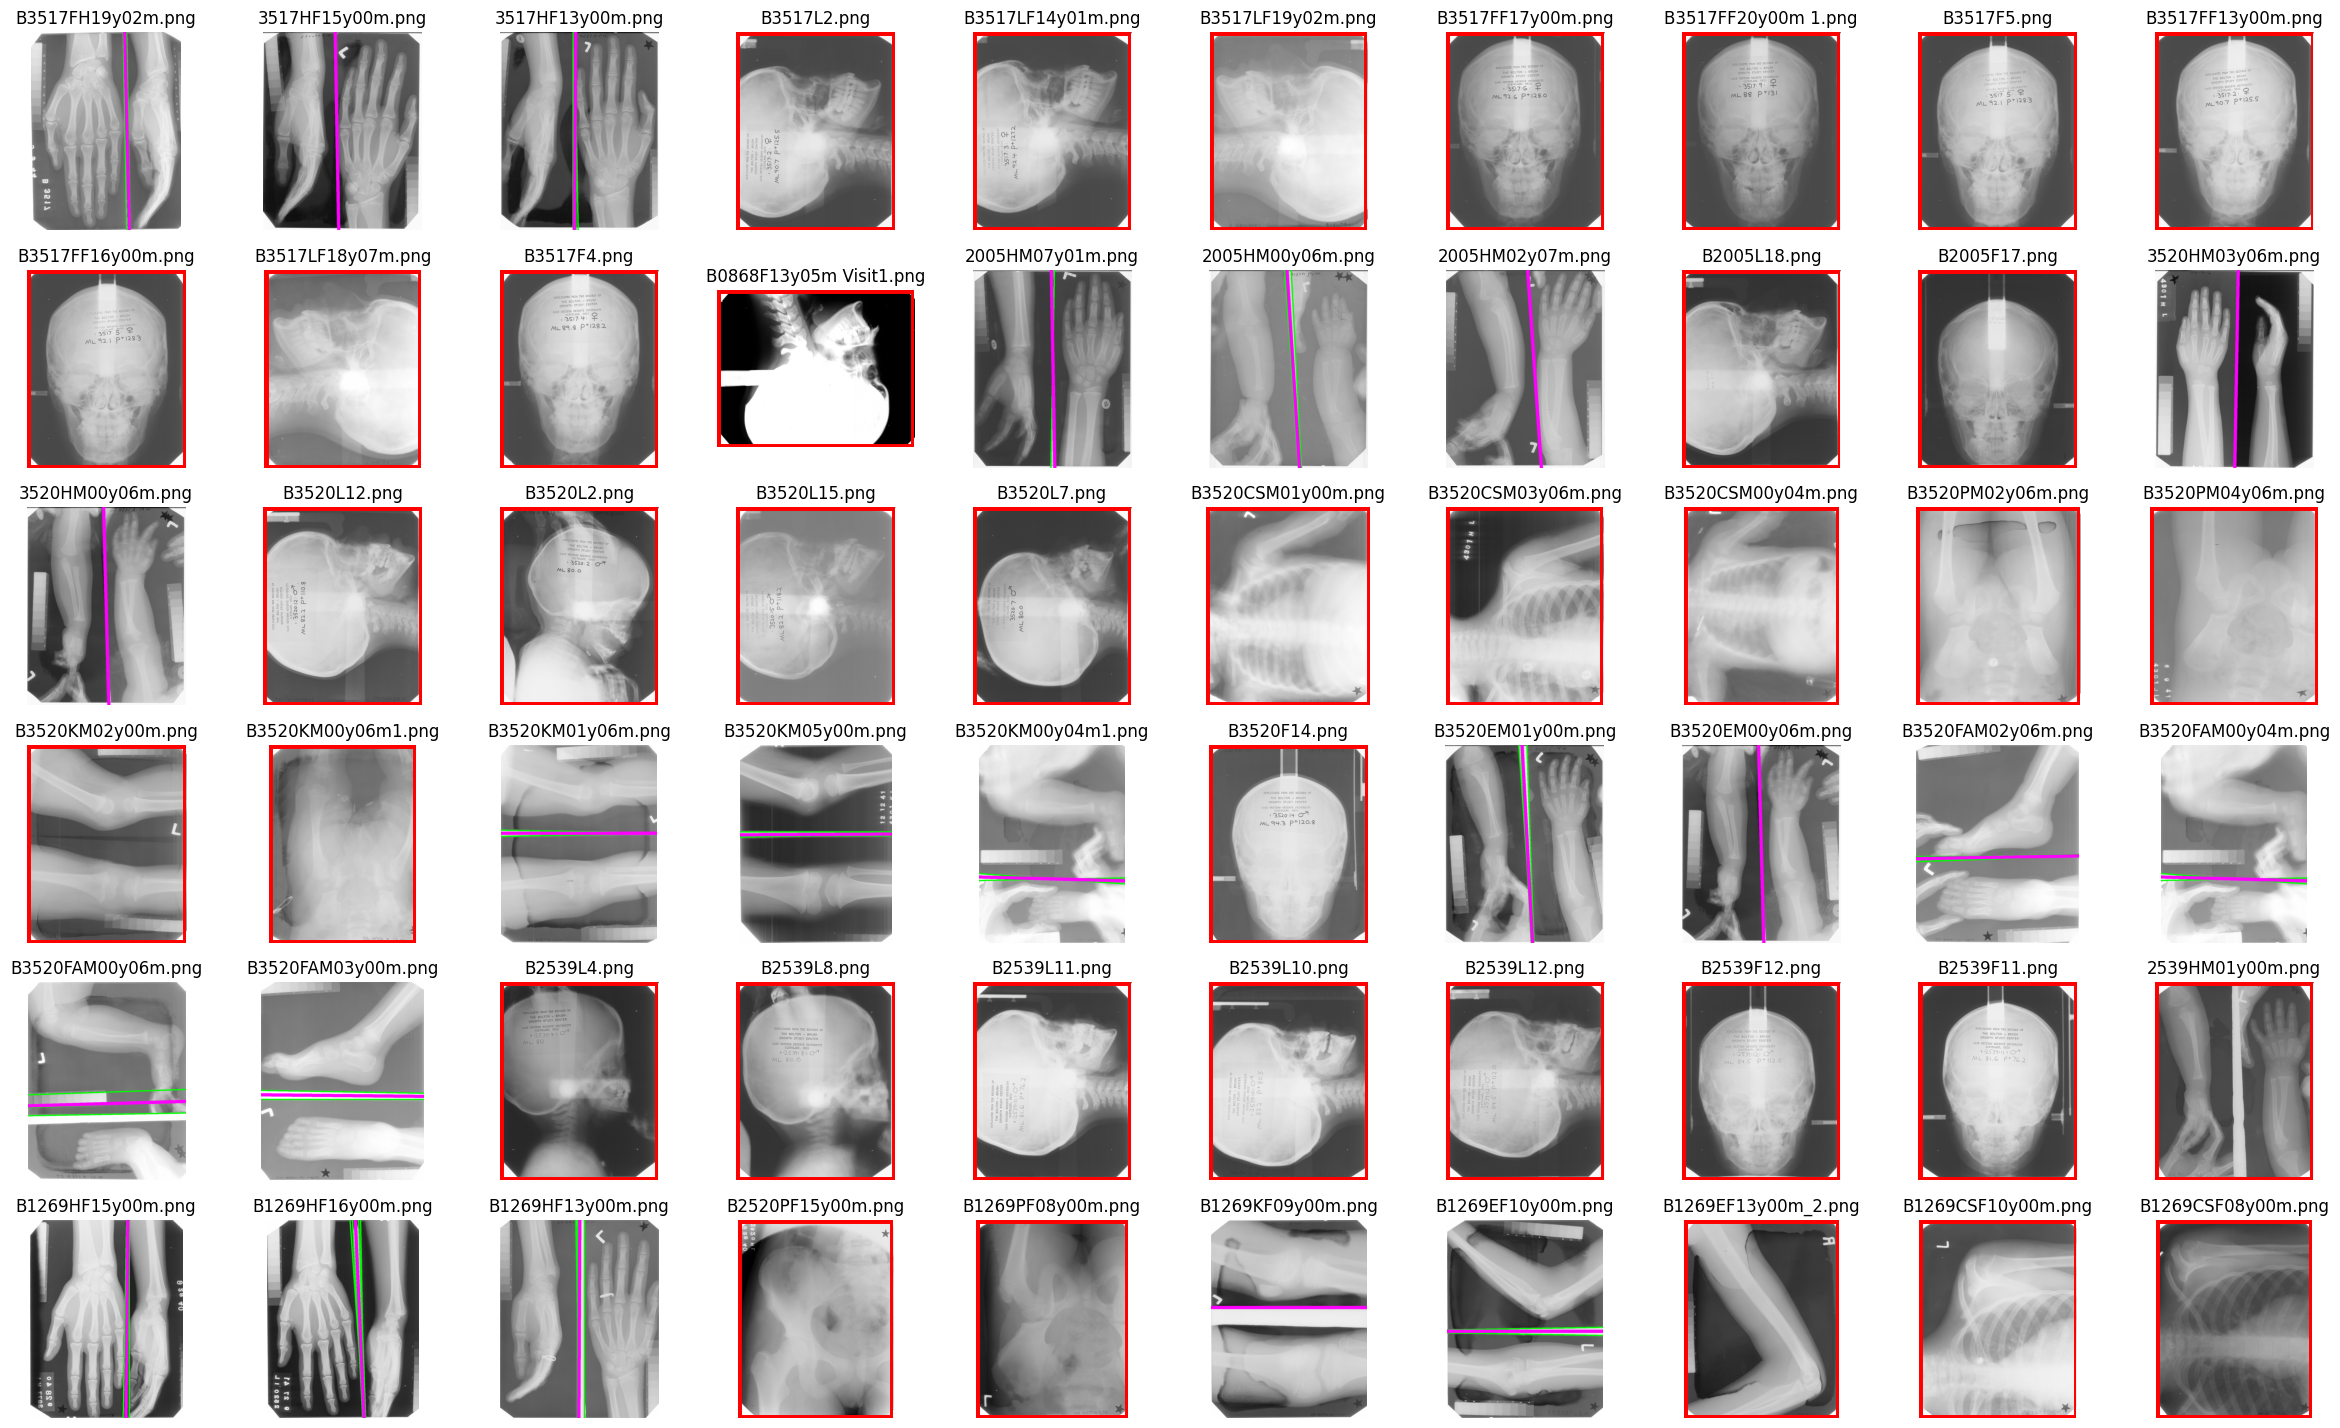

Misses/Total: 6777/9752


In [23]:
folder = Path('Scans')
scans = list(folder.rglob('*.png'))
n_images = len(scans)
print(f"Total images to process: {n_images}")
n_cols = 10
n_rows = 6
max_imgs = n_cols * n_rows
img_count = 0
subplot_size = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*subplot_size, n_rows*subplot_size))
axs = axs.ravel()

for ax in axs[n_images:]:
    ax.axis('off')

with Pool() as p:
    results = p.map(process_image, scans)

misses = 0
for idx, result in enumerate(results):
    img, rect, split = result
    if(rect is not None):
        misses += 1
    if(img_count < max_imgs and rnd.random() > 0.75):
        axs[img_count].imshow(img)
        axs[img_count].axis('off')
        axs[img_count].set_title(scans[idx].name)
        if rect is not None:
            axs[img_count].add_patch(rect)
        img_count += 1

plt.show()
print(f"Misses/Total: {misses}/{len(scans)}")

## Classic image-processing algorithms: Insights and Observations
---
The unorganized structure of the dataset forced us to apply the computation to all files in the training-set.  
This approach ended up with a considerable amount of images with no split found (roughly 3/4), and necessitates manual inspection for telling apart single scans (*false negatives*) from double scans.  
![Example false negatives](images/false_negatives.png "false negatives")  
The varying quality of the scans also led to a non-negligible number of *false positives* (single scans for which a split is "hallucinated") and incorrect splits (the image consists of two X-rays, but the detected split position is incorrect).  
![Example false positives](images/false_positives.png "false positives")  
Furthermore, the presence of some instances of 'triple scans' within the training-set, presented an even greater challenge for the classic image-processing approach.  
![Example triple scan](images/triple_scan.png "triple scan")  
We can conclude that the "classic image-processing" approach is not feasible for the task of developing a reliable method to split double X-ray scans in the BB-Collection.  
Therefore it would be highly beneficial to investigate more robust deep-learning methods.

## Testing a Hybrid Approach
---
#### Why Choose When You Can Have Both?
As initially stated, a deep-learning approach to segmentation would necessitate a laborious and time-consuming labeling process to prepare a suitable training set.  
We can divide the problem into two separate, smaller tasks:
- Determine whether a scan needs to be split (classification problem).
- Find an optimal split position for scans that need to be split.

In this scenario, the first step can be accomplished by a simpler classification model, for which the labeling process is easier and quicker. We simply need two folders containing examples of scans that need to be split and those that don't, respectively.  
For the second step, we can leverage the classic approach we already developed. However, now we can safely assume that the passed scans all need to be split, eliminating the problem of *false positives* and the problem of distinguishing "no split found" cases from *false negatives*.  

Next we load an image classification model and fine-tune it on a small training-set consisting of two example folders: *split*, *nosplit*.

In [6]:
path = "Train"
files = get_image_files(path)
len(files)

1966

In [8]:
def label_func(f):
    if(f.parent.name) == "split":
        return True
    else:
        return False

In [6]:
set_seed(42, True)
dls = ImageDataLoaders.from_path_func(path, files, label_func,
                                  item_tfms=Resize(size=460, method=ResizeMethod.Squish),
                                      batch_tfms=aug_transforms(),
                                      seed=42)

In [7]:
# dls.show_batch(max_n=3)

In [8]:
learn = vision_learner(dls, models.resnet34, metrics=accuracy)
learn.to_fp16()

/home/frenchfaso/miniconda3/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/frenchfaso/miniconda3/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.0010000000474974513

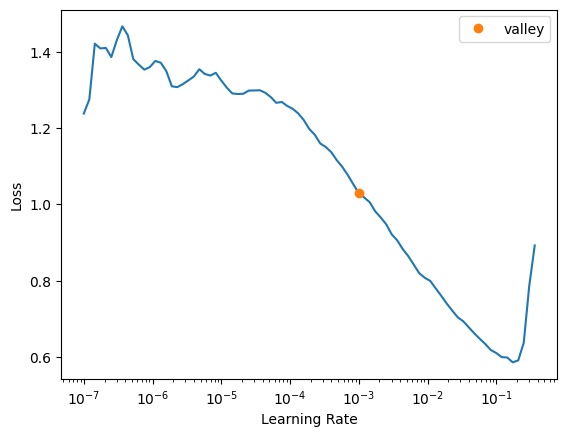

In [9]:
lr = learn.lr_find()
lr.valley

In [10]:
learn.fine_tune(25, lr.valley)

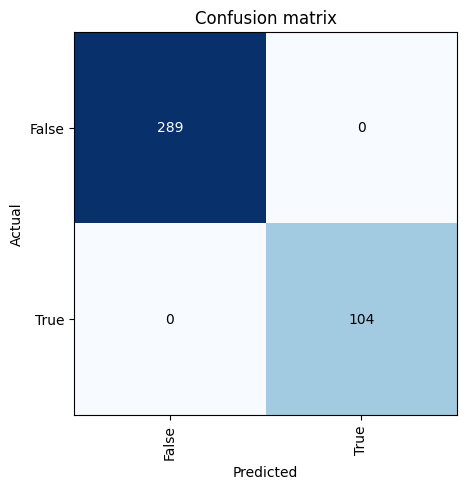

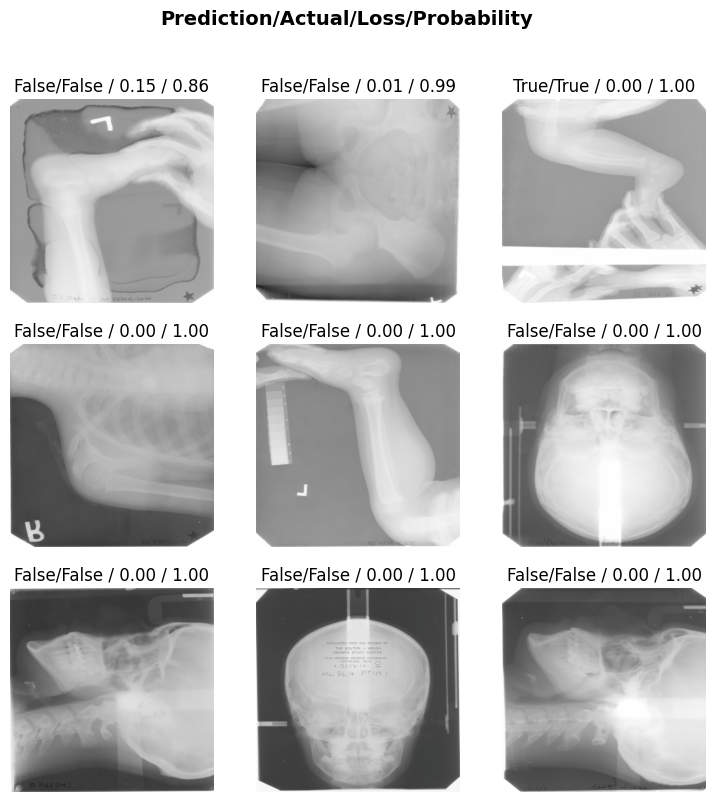

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(9)

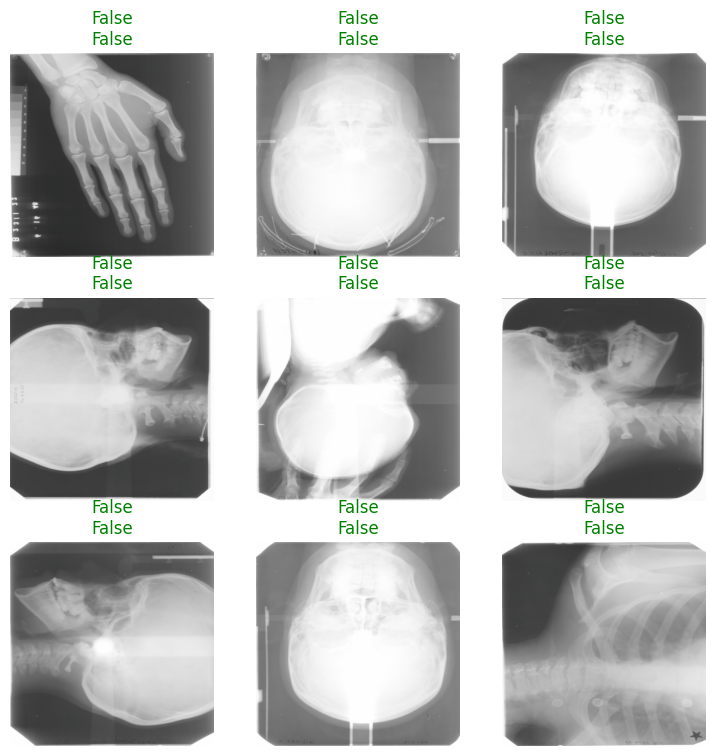

In [12]:
learn.show_results()

#### Saving the Trained Model
After completing a training run of 25 epochs, the model demonstrated 100% accuracy when tested against the validation set (this set represents 20% of the total training set). For efficiency in future use, we store the trained model as a binary file. This allows for quick loading in subsequent inference sessions. These are instances where we use the model to predict whether arbitrary scans (those not seen before by the model) need to be split.  
Next, to further assess our model's performance, we run a test on the *Scan* folder. In this test, the model evaluates scans until it has selected 30 scans to be *split* and 30 scans to remain as they are.  
The goal here is to confirm the model's ability to accurately categorize new scans, thereby increasing our confidence in its predictive abilities. Please note that these scans are not pre-selected, but are determined by the model during the test run.  
For the scans that the model predicts need to be split, we apply our previous *classic image processing* algorithm and mark those for which the classic algorithm couldn't find a "split" with a red rectangle.

In [15]:
learn.path = Path("./")
learn.export("resnet34_fp16_02")

In [9]:
learn = load_learner("models/resnet34_fp16_02")
folder = Path('Scans')
scans = list(folder.rglob('*.png'))
n_images = len(scans)

Samples: 60


/home/frenchfaso/miniconda3/envs/fastai/lib/python3.11/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


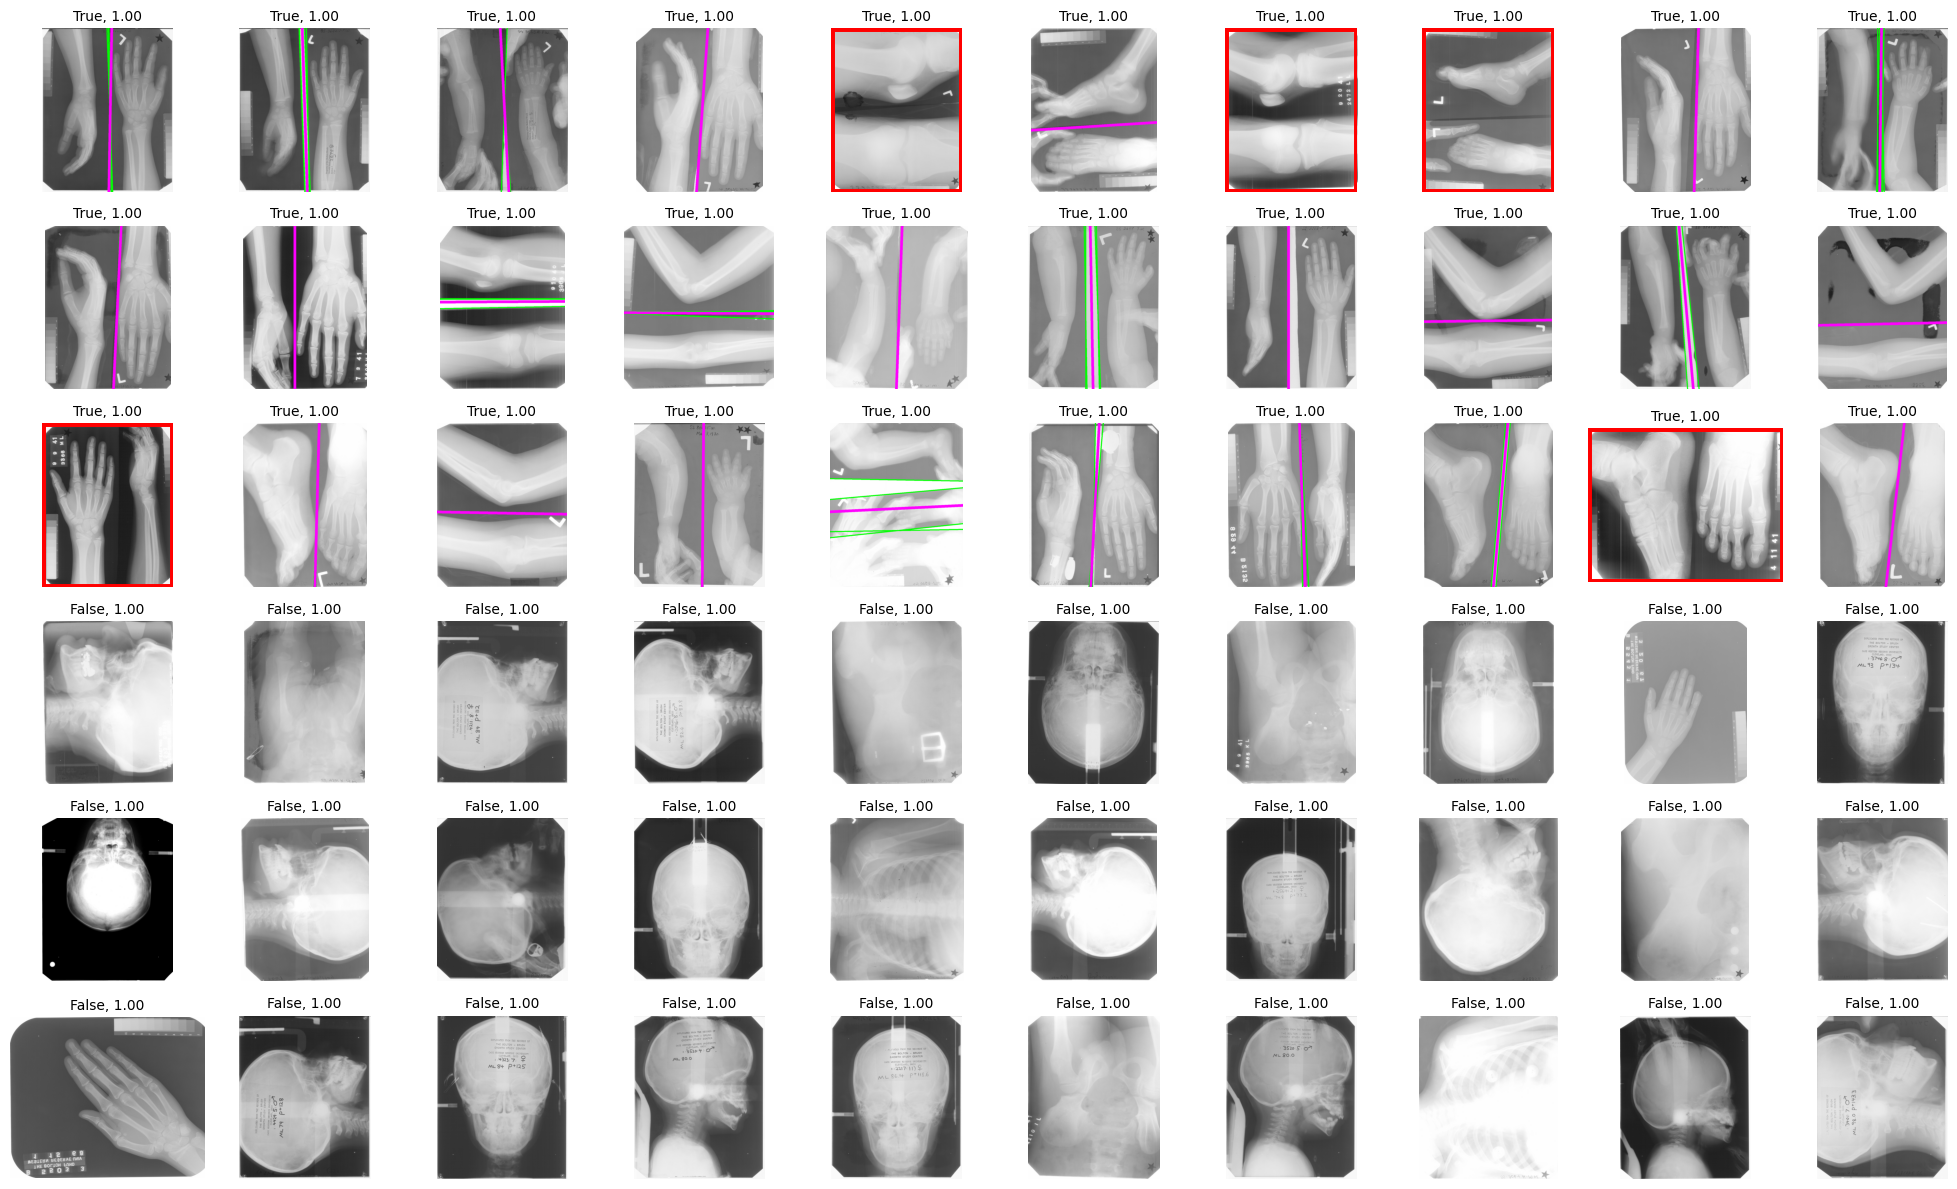

In [10]:
# Specify the number of rows and columns
rows = 6
cols = 10
n = rows * cols
print(f"Samples: {n}")

rnd.shuffle(scans)
split, nosplit = [], []
count = 0

for x in scans:
    pred = learn.predict(x)
    if pred[0] == 'True':
        split.append((x, pred))
        count += 1
    if count >= n/2:
        break

for x in scans:
    pred = learn.predict(x)
    if pred[0] == 'False':
        nosplit.append((x, pred))
        count += 1
    if count >= n:
        break

subplot_size = 2 
figsize = (cols * subplot_size, rows * subplot_size)

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

for idx, pred in enumerate(split + nosplit):
    # Find the confidence by taking the max of the output probabilities
    confidence = max(pred[1][2]).item()

    # Load the image
    if (idx < n/2):
        img, rect, split = process_image(pred[0])
        if(rect is not None):
            axes[idx].add_patch(rect)
    else:
        img = Image.open(pred[0])
        
    # Get the current axes
    ax = axes[idx]
    ax.imshow(img)
    ax.set_title(f'{pred[1][0]}, {confidence:.2f}',fontsize=subplot_size*5)
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

## Hybrid Approach: Insights and Observations
---
Combining the *classic image processing* algorithm with a *deep learning* classification model shows promising results. With an accuracy of 100% on the validation set, we can safely assume that virtually every scan that reaches the classic algorithm for split determination indeed needs to be split. Therefore, virtually every scan for which the combined algorithm can't find a split is likely a *false negative*.  

It should be noted, however, that any possible false positives reaching the second step of the process could still be filtered out by the classic image processing algorithm if it fails to find a split. Additionally, the deep learning model may miss some scans that actually need to be split.  
Furthermore, as previously observed, the classic algorithm may not always correctly locate the split. 

Although this hybrid approach greatly outperforms the previous method, further testing of a "pure DL" approach, such as a *segmentation model*, could be highly beneficial.